# Book Genre Classification - Multi Label Text Classification

In this tutorial, I will show you how to predict Genres for the description of a books. Firstly, we will build a multi-label model that’s capable of detecting different types of genre in a large number of book descriptions. 

Some types of Genre are:
Adventure<br>
Fiction<br>
Alien invasion<br> 
Zombie<br>
Alien invasion


## The data set used can be downloaded from 
http://www.cs.cmu.edu/~dbamman/booksummaries.html#:~:text=This%20dataset%20contains%20plot%20summaries,Creative%20Commons%20Attribution%2DShareAlike%20License .<br>
The dataset contains plot summaries for 16,559 books extracted from Wikipedia, along with aligned metadata from Freebase, including book author, title, and genre.


## To solve this task you will use multilabel classification approach.
Libraries used are: <br>

Numpy — a package for scientific computing.<br>
Pandas — a library providing high-performance, easy-to-use data structures and data analysis tools for the Python<br>
scikit-learn — a tool for data mining and data analysis.<br>
NLTK — a platform to work with natural language.<br>
Seaborn - library used to visualize and plot graphs.<br>

The data set contains text data and corresponding Genre. For easy operation on the data, let us load pandas and numpy that we will use to structure our data and do operations on the data. let’s also deploy matplotlib that we will use for visualisation

In [1]:
import sys

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re
import csv

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /Users/akhil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Read the data From Text File

Let us create a list called data. Append all the text from the file into the list. 

In [2]:
data = []

with open("booksummaries.txt") as f:
    reader = csv.reader(f,dialect = 'excel-tab')
    for text in reader:
        data.append(text)

# Convert the List into a dataframe

In [3]:
book_id = []
book_name = []
book_author = []
book_publishedyear = [] 
summary = []
genre = []

for i in data:
    book_id.append(i[0])
    book_name.append(i[2])
    book_author.append(i[3])
    book_publishedyear.append(i[4])
    genre.append(i[5])
    summary.append(i[6])

books = pd.DataFrame({'book_id': book_id, 'book_name': book_name, 'book_author' : book_author, 
                      'book_publishedyear' : book_publishedyear, 'genre': genre, 'summary': summary})

Now that data is in a dataframe let's see some statistics using "describe()". It is a pandas inbuilt function.

In [4]:
books.describe()

,book_id,book_name,book_author,book_publishedyear,genre,summary
count,16559,16559,16559,16559,16559,16559
unique,16559,16277,4715,2640,2155,16532
top,973112,Nemesis,,,,~Plot outline description~ --> <!--
freq,1,6,2382,5610,3718,13


Let us see the the snapshot of our data in the dataFrame. We will observe that before the data is cleaned, there are 16559 and 6 columns showing each books's features. 

In [5]:
books

,book_id,book_name,book_author,book_publishedyear,genre,summary
0,620,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,An Enquiry Concerning Human Understanding,David Hume,,,The argument of the Enquiry proceeds by a ser...
4,2080,A Fire Upon the Deep,Vernor Vinge,,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...
...,...,...,...,...,...,...
16554,36934824,Under Wildwood,Colin Meloy,2012-09-25,,"Prue McKeel, having rescued her brother from ..."
16555,37054020,Transfer of Power,Vince Flynn,2000-06-01,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction""}",The reader first meets Rapp while he is doing...
16556,37122323,Decoded,Jay-Z,2010-11-16,"{""/m/0xdf"": ""Autobiography""}",The book follows very rough chronological ord...
16557,37132319,America Again: Re-becoming The Greatness We Ne...,Stephen Colbert,2012-10-02,,Colbert addresses topics including Wall Stree...


# clean genre

1 ) First drop all the empty genre's. <br>
2 ) Put all the cleaned genre into a new column "genre_new" in the dataframe.<br>
3 ) check the length of the dataframe to see if there were any changes made.<br>
4 ) Print the unique number of genere's. <br>

In [6]:
books.drop(books[books['genre']==''].index, inplace=True)
books[books['genre']=='']

,book_id,book_name,book_author,book_publishedyear,genre,summary


In [7]:
genres = []
for i in books['genre']:
    genres.append(list(json.loads(i).values()))
books['genre_new'] = genres

In [8]:
# The length has gone down from 16,559 to 12,841. Since we removed the rows with empty genre'.
len(books)

12841

In [9]:
# Number of unique labels. 
all_genres = sum(genres,[])
len(set(all_genres))

227

# Visualize the top 30 Frequent words in the Summary

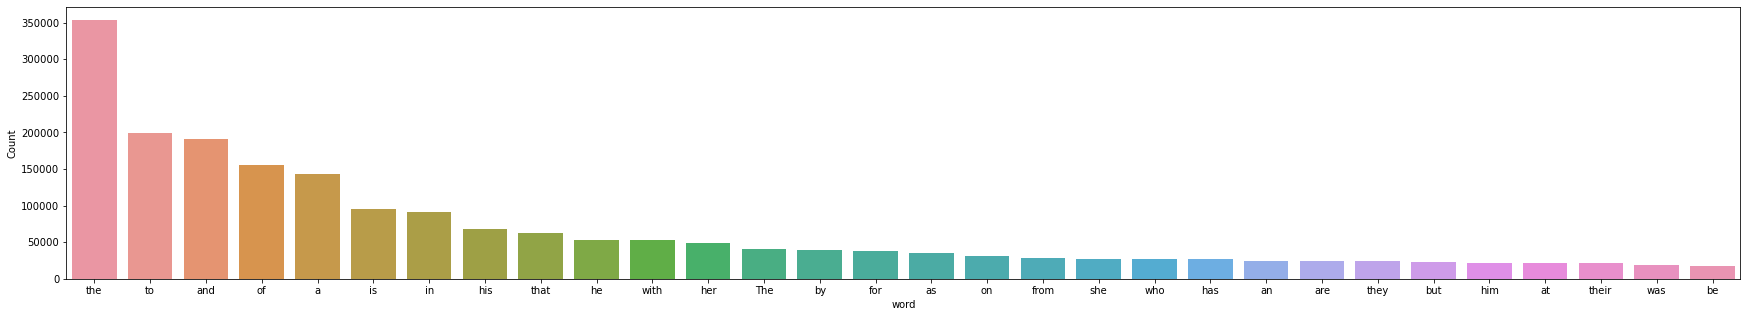

In [10]:
# FreqDist helps to count the number of times that each outcome of an experiment occurs.
from nltk import FreqDist
import seaborn as sns

def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # Visualizing top 30 most frequent words along with their frequency.
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(30,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

freq_words(books['summary'])

# Conver "New-genres" into One-Hot-Encoding with MultiLabelBinarizer

Multilabelbinarizer allows you to encode multiple labels per instance. To translate the resulting array, you could build a DataFrame with this array and the encoded classes (through its "classes_" attribute).

For example, if I have this DataFrame:<br>

df = pd.DataFrame({"genre": [["action", "drama","fantasy"], ["fantasy","action"], ["drama"], ["sci-fi", "drama"]]})


## apply MultiLabelBinarizer to the genre column:

mlb = MultiLabelBinarizer()<br>
df = pd.DataFrame(mlb.fit_transform(df['genre']),columns=mlb.classes_)<br>


## The result will be as follows:<br>

action ---- drama ---- fantasy ---- sci-fi<br>
    1-------------1 ----------      1   -----------     0   <br>
    1-------------         0  ----------        1  ----------          0   <br>
    0-------------         1  ----------        0  ----------          0   <br>
    0-------------         1  ----------        0  ----------          1   <br>

In [11]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(books['genre_new'])

# transform target variable. It will have a shape of (12841, 227). 
y = multilabel_binarizer.transform(books['genre_new'])


# Convert Genres into DataFrame

1) create an array of shape (1,277) (i.e it has 277 of 1's) <br>
2) use multilabel_binarizer.inverse_transform() to Transform the given indicator matrix into label sets<br>
3) convert the label set into a list <br>
4) Convert the list into a dataframe<br>

In [12]:
array = np.ones(227).reshape(1,227)
array.shape

(1, 227)

In [13]:
genres_list = list(multilabel_binarizer.inverse_transform(array)[0])

In [14]:
genres_list

['Absurdist fiction',
 'Adventure',
 'Adventure novel',
 'Albino bias',
 'Alien invasion',
 'Alternate history',
 'American Gothic Fiction',
 'Anthology',
 'Anthropology',
 'Anti-nuclear',
 'Anti-war',
 'Apocalyptic and post-apocalyptic fiction',
 'Autobiographical comics',
 'Autobiographical novel',
 'Autobiography',
 'Bangsian fantasy',
 'Bildungsroman',
 'Biographical novel',
 'Biography',
 'Biopunk',
 'Bit Lit',
 'Black comedy',
 "Boys' school stories",
 'Business',
 'Cabal',
 'Campus novel',
 'Catastrophic literature',
 'Chick lit',
 "Children's literature",
 'Chivalric romance',
 'Collage',
 'Colonial United States romance',
 'Comedy',
 'Comedy of manners',
 'Comic book',
 'Comic fantasy',
 'Comic novel',
 'Comic science fiction',
 'Comics',
 'Coming of age',
 'Computer Science',
 'Conspiracy',
 'Conspiracy fiction',
 'Contemporary fantasy',
 'Cookbook',
 'Cozy',
 'Creative nonfiction',
 'Crime Fiction',
 'Cyberpunk',
 'Dark fantasy',
 'Detective fiction',
 'Drama',
 'Dying Earth

In [15]:
genres_matrix = pd.DataFrame(y,columns=genres_list)

In [16]:
genres_matrix

,Absurdist fiction,Adventure,Adventure novel,Albino bias,Alien invasion,Alternate history,American Gothic Fiction,Anthology,Anthropology,Anti-nuclear,...,Vampire fiction,War novel,Western,Western fiction,Whodunit,Wuxia,Young adult literature,Youth,Zombie,Zombies in popular culture
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12836,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12837,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12838,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12839,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Concat the New genre dataFrame with books dataFrame to get the Complete Dataframe to perform Further Analysis.

1) Reset the index of both books dataframe and genre dataframe. This is done because "Concat" works by joining based on the Index of the 2 dataFrames. If the DataFrames Indexes are not the same and concat is used, then the joined dataFrame will have un-matched rows with Nan. 

2) Use Pd.Concat to concatinate the 2 Dataframes into - Books DataFrame

3) check to see the concatinated dataframe - Books DataFrame

In [17]:
genres_matrix.reset_index(drop=True,inplace=True)
books.reset_index(drop=True,inplace=True)

In [18]:
genres_matrix
print(len(genres_matrix))
print(len(books))

12841
12841


In [19]:
books = pd.concat([books, genres_matrix], axis=1)

In [20]:
y.shape

(12841, 227)

In [21]:
books

,book_id,book_name,book_author,book_publishedyear,genre,summary,genre_new,Absurdist fiction,Adventure,Adventure novel,...,Vampire fiction,War novel,Western,Western fiction,Whodunit,Wuxia,Young adult literature,Youth,Zombie,Zombies in popular culture
0,620,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca...","[Roman à clef, Satire, Children's literature, ...",0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,843,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan...","[Science Fiction, Novella, Speculative fiction...",0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,986,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...,"[Existentialism, Fiction, Absurdist fiction, N...",1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2080,A Fire Upon the Deep,Vernor Vinge,,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...,"[Hard science fiction, Science Fiction, Specul...",0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2152,All Quiet on the Western Front,Erich Maria Remarque,1929-01-29,"{""/m/098tmk"": ""War novel"", ""/m/016lj8"": ""Roman...","The book tells the story of Paul Bäumer, a Ge...","[War novel, Roman à clef]",0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12836,36372465,The Third Lynx,Timothy Zahn,2007,"{""/m/06n90"": ""Science Fiction""}",The story starts with former government agent...,[Science Fiction],0,0,0,...,0,0,0,0,0,0,0,0,0,0
12837,36534061,Remote Control,Andy McNab,1997,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction...",The series follows the character of Nick Ston...,"[Thriller, Fiction, Suspense]",0,0,0,...,0,0,0,0,0,0,0,0,0,0
12838,37054020,Transfer of Power,Vince Flynn,2000-06-01,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction""}",The reader first meets Rapp while he is doing...,"[Thriller, Fiction]",0,0,0,...,0,0,0,0,0,0,0,0,0,0
12839,37122323,Decoded,Jay-Z,2010-11-16,"{""/m/0xdf"": ""Autobiography""}",The book follows very rough chronological ord...,[Autobiography],0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Split the Data into Training, Test and Validation Set

1) Import train_test_split from sKlearn to split the data. 

In [22]:
from sklearn.model_selection import train_test_split

# split to Train and Test Set
train_set, test = train_test_split(books, random_state=2, test_size=0.1, shuffle=True)

In [23]:
# Split the remaining to train and validation set
train, validation = train_test_split(train_set, random_state=42, test_size=0.1, shuffle=True)

# visulaize the generes and their Occurneces

1) count the number of labels per genre. <br>
    &nbsp;&nbsp;&nbsp; a)Do this by dropping all the unncessary columns to get all the genre(category) columns<br>
2) Print to see the stats of all the genre in <br> 
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;a) Train set <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;b) Validation Set <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;c) Test Set
    
3) Plot the graphs for the 3 sets 

In [24]:
def count_labels_per_category(df):
    
    df_label = df.drop(['book_id', 'book_name', 'book_author', 'book_publishedyear','summary','genre','genre_new'], axis=1)
    print(df_label)
    counts = []
    genres = list(df_label.columns.values)
    for i in genres:
        counts.append((i, df_label[i].sum()))
    df_stats = pd.DataFrame(counts, columns=['genres', 'number_of_genres'])
    return df_stats

In [25]:
df_stats_train = count_labels_per_category(train)
print(df_stats_train)
df_stats_valid = count_labels_per_category(validation)
print(df_stats_valid)
df_stats_test = count_labels_per_category(test)
print(df_stats_test)

       Absurdist fiction  Adventure  Adventure novel  Albino bias  \
6416                   0          0                0            0   
8558                   0          0                0            0   
9820                   0          0                0            0   
8719                   0          0                0            0   
2849                   0          0                0            0   
...                  ...        ...              ...          ...   
6481                   0          0                0            0   
2154                   0          0                0            0   
6475                   0          0                0            0   
9645                   0          0                0            0   
11767                  0          0                0            0   

       Alien invasion  Alternate history  American Gothic Fiction  Anthology  \
6416                0                  0                        0          0   
8558       

In [26]:
def plot_count_labels_per_category(df_stats):
    df_stats.plot(x='genres', y='number_of_genres', kind='bar', legend=False, grid=True, figsize=(8, 5))
    plt.title("Number of Occurences per Genre")
    plt.ylabel('# of Occurrences', fontsize=12)
    plt.xlabel('Genres', fontsize=12)

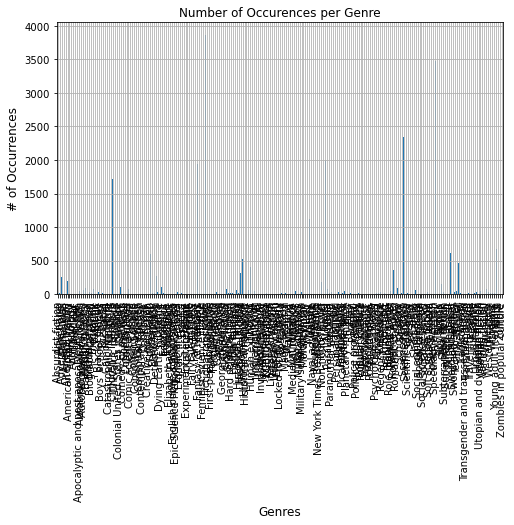

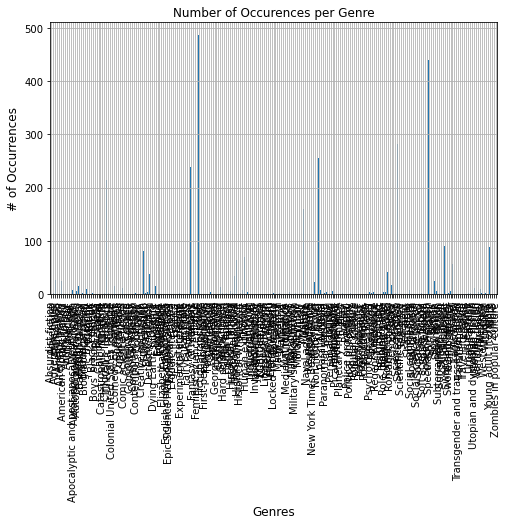

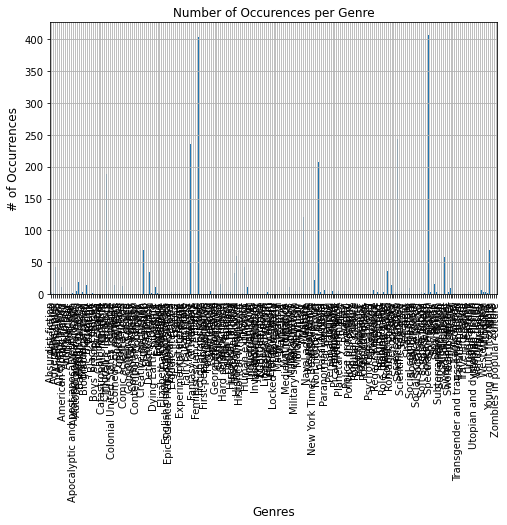

In [27]:
plot_count_labels_per_category(df_stats_train)
plot_count_labels_per_category(df_stats_test)
plot_count_labels_per_category(df_stats_valid)

Although we now know the occurences of genre, we still lack the big picture since as we know in any multi label problem, one text can be assigned to multiple tags or genre . <b>so we need to understand how many descriptions have zero genre, how many descriptions have only one genre, how many descriptions assigned just two genre, etc…</b>


/Users/akhil/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, '# of Genres')

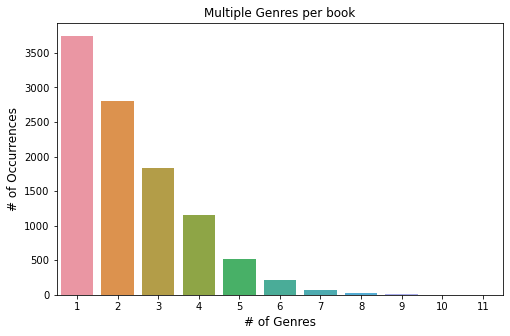

In [28]:
import seaborn as sns

rowsums = train.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple Genres per book")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of Genres', fontsize=12)

This indeed just revealed something not surprising but important to know. 
1) most of our Descriptions have 1-4 genres. <br>
2) No Descriptions has all Genres at a time. <br>

# Visualize Summary or Descriptions

So far we have been looking at the distribution of the Genres. what about the composition of our summary data? as a matter of curiosity, let see how big are texts in general

<AxesSubplot:>

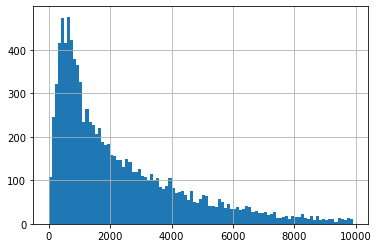

In [29]:
lens = train.summary.str.len()
lens.hist(bins = np.arange(0,10000,100))

In [30]:
print('Number of missing summarys on Training set:')
train['summary'].isnull().sum()

Number of missing summarys on Training set:


0

In [31]:
print('Number of missing summarys on Validation set:')
validation['summary'].isnull().sum()

Number of missing summarys on Validation set:


0

### we can observe that

1) The maximum summary's text have a length between 400 and 500 charecters<br>
2) the number of summarys missing in training set and validation set are zero thus proving that we have cleaned the data properly by removing the null rows.


## Let’s split the input data from the ground truth labels.

In [32]:
X_train, y_train = train['summary'].values, train.iloc[:,7:].values
X_val, y_val = validation['summary'].values, validation.iloc[:,7:].values
X_test, y_test = test['summary'].values, test.iloc[:,7:].values

In [33]:
print('X_train shape ', X_train.shape)
print('y_train shape ', y_train.shape)
print('X_val shape ', X_val.shape)
print('y_val shape ', y_val.shape)
print('X_test shape ', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape  (10400,)
y_train shape  (10400, 227)
X_val shape  (1156,)
y_val shape  (1156, 227)
X_test shape  (1285,)
y_test shape (1285, 227)


In [34]:
X_train

array([' A young Bernice Summerfield lands a job as an archaeologist on a colony world. She discovers evidence that the planet was previously inhabited by a sapient species.',
       ' Orrie is finally going to tie the knot. He\'s engaged to marry Jill Hardy, a stewardess. But for months, Orrie\'s also been keeping company with Isabel Kerr, an ex-showgirl. Orrie has some time available because Jill works international flights. Isabel has time available because she no longer performs: rather, she occupies a plush apartment that\'s paid for by another gentleman friend who visits her just two or three times a week. Isabel objects to Orrie\'s marriage plans. She has taken some of his personal and professional belongings and stashed them in her apartment. Isabel threatens to show them to Jill and thus quash the marriage. So, Orrie asks Archie to get into Isabel\'s apartment, find his possessions, and get them back. When Archie does enter the apartment, he finds not Orrie\'s belongings but I

In [35]:
train.columns

Index(['book_id', 'book_name', 'book_author', 'book_publishedyear', 'genre',
       'summary', 'genre_new', 'Absurdist fiction', 'Adventure',
       'Adventure novel',
       ...
       'Vampire fiction', 'War novel', 'Western', 'Western fiction',
       'Whodunit', 'Wuxia', 'Young adult literature', 'Youth', 'Zombie',
       'Zombies in popular culture'],
      dtype='object', length=234)

Our labels need to be formatted. we need to list all genres of a summary. for example: summary 1 will have a 'e.t.c'. summary 3 will have an array containing ' fiction' , 'e.t.c', 'e.t.c' and so on. 

In [36]:
# Create dictionary
dictionary = {i:genres_list[i] for i in range(0, len(genres_list))}
dictionary

{0: 'Absurdist fiction',
 1: 'Adventure',
 2: 'Adventure novel',
 3: 'Albino bias',
 4: 'Alien invasion',
 5: 'Alternate history',
 6: 'American Gothic Fiction',
 7: 'Anthology',
 8: 'Anthropology',
 9: 'Anti-nuclear',
 10: 'Anti-war',
 11: 'Apocalyptic and post-apocalyptic fiction',
 12: 'Autobiographical comics',
 13: 'Autobiographical novel',
 14: 'Autobiography',
 15: 'Bangsian fantasy',
 16: 'Bildungsroman',
 17: 'Biographical novel',
 18: 'Biography',
 19: 'Biopunk',
 20: 'Bit Lit',
 21: 'Black comedy',
 22: "Boys' school stories",
 23: 'Business',
 24: 'Cabal',
 25: 'Campus novel',
 26: 'Catastrophic literature',
 27: 'Chick lit',
 28: "Children's literature",
 29: 'Chivalric romance',
 30: 'Collage',
 31: 'Colonial United States romance',
 32: 'Comedy',
 33: 'Comedy of manners',
 34: 'Comic book',
 35: 'Comic fantasy',
 36: 'Comic novel',
 37: 'Comic science fiction',
 38: 'Comics',
 39: 'Coming of age',
 40: 'Computer Science',
 41: 'Conspiracy',
 42: 'Conspiracy fiction',
 43

Create a function called convertClass that convert our genres as described above.for comments which are unknown, add a new tag called unknown

In [37]:
def convertClass(tags,classes):
    result = []
    for i,tag in enumerate(tags):
        if tag > 0:
            result.append(classes[i])
    if len(result) == 0:
        result.append('unknown')
                
    return result

Let’s run our function to all labels data

In [38]:
y_train = np.array([convertClass(tag,dictionary) for tag in y_train])
y_val = np.array([convertClass(tag,dictionary) for tag in y_val])
y_test = np.array([convertClass(tag,dictionary) for tag in y_test])

/Users/akhil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/Users/akhil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/Users/akhil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you 

In [39]:
y_train

array([list(['Speculative fiction']),
       list(['Detective fiction', 'Fiction', 'Mystery', 'Suspense']),
       list(['Fiction', 'Horror']), ..., list(['Horror', 'Short story']),
       list(['Horror', 'Mystery', 'Speculative fiction', 'Young adult literature']),
       list(['Non-fiction'])], dtype=object)

# Clean Summary 

Our data is almost ready for training. but one more thing needs to be done. we need to clean the summary by:<br>
1) Removing wrong characters such as special characters. <br>
2) Need to change the case of all characters that make the comment to avoid case insensitivity our models. <br>
3) Need to remove stop words since those are words that are likely to be common to all comments.<br>

In [40]:
# print uncleaned Data
X_train[2]

" The Ravenous introduces us to Eddie Spears, a teenager who is into video games and hanging out with his best friend, Jess Brown. Eddie has a problem: he can hear distant whispers and this causes severe headaches. When he discovers the true cause for his town's prosperity: a sacrificial pseudo-Druid cult, Eddie comes to realize he has a special gift—but can he use it in time to save his sister's life?"

In [41]:
import re 
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
NEW_LINE = re.compile('\n')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()# lowercase text
    text = NEW_LINE.sub(' ',text) # replace NEW_LINE symbols in our texts by space
    text = REPLACE_BY_SPACE_RE.sub(' ',text)# replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('',text)# delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join([word for word in text.split() if word not in STOPWORDS])
    return text

In [42]:
# Clean the test, train and validation set summary
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

Let's print to see if the summary is cleaned. 

In [43]:
X_train[2]

'ravenous introduces us eddie spears teenager video games hanging best friend jess brown eddie problem hear distant whispers causes severe headaches discovers true cause towns prosperity sacrificial pseudodruid cult eddie comes realize special giftbut use time save sisters life'

# Data Transformation

Once the data is cleaned. We have moved onto the next step which is data transformation.<br>

In this section we will transform our input text into vectors of numbers that represent each word that makes the training corpus. <br>
<b>Let’s first create two dictionaries</b> <br>
<b>one to hold all words and the number of times they have been used across the corpus. </b><br>
<b>another to hold all genres and the number of times they have been assigned a summary. </b><br>

These two will be used later when we want to check what the model is learning about some of the most important words in the corpus.

In [44]:
# Dictionary of all tags from train corpus with their counts.
tags_counts = {}
for tags in y_train:
    for tag in tags:
        if tag in tags_counts:
            tags_counts[tag] += 1
        else:
            tags_counts[tag] = 1
# Dictionary of all words from train corpus with their counts.
words_counts = {}

for title in X_train:
    for word in title.split():
        if word in words_counts:
            words_counts[word] += 1
        else:
            words_counts[word] = 1

In [45]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:5]
print('Common tags',most_common_tags)
print('-----------------')
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:5]
print('common words',most_common_words)

Common tags [('Fiction', 3857), ('Speculative fiction', 3468), ('Science Fiction', 2344), ('Novel', 2000), ('Fantasy', 1940)]
-----------------
common words [('one', 11621), ('time', 7573), ('also', 7335), ('two', 7134), ('new', 6891)]


There are different ways we can represent each word in a numerical way. The most common are : <br>
1) bag of words <br> 
2) TFIDF <br>
3) Word Embeddings.<br> 
The later has recently attracted attention of many especially when you have a big corpus of millions of words(including n-grams). <br>

<b>For this exercise</b>, I will use <b>TFIDF</b> which is an <b>improved version of bag of words</b> which uses inversed logarithmic normalisation to penalise those words that are most frequent accross different input text of our corpus.<br>

Let’s use sklearn library to generate tfidf vectors. I will also use n-grams of size 1 and two. you can experiment with size if you have enough RAM on your computer. Also keep in mind that increasing the size of n-grams without increasing the size of samples might generate a lot of features than the size of the sample. this can result into your model being high biased.

In [46]:
#Create a function that convert each set of our traing, validation and test corpus into a TFIDF matrix

from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    
    tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.4, ngram_range=(1, 2),token_pattern='(\S+)')
    tfidf_vectorizer.fit(X_train)
    X_train = tfidf_vectorizer.transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test)
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

Run the functiion agains the <b>training set, validation and the test</b>. </br>

check if most common words of our corpus are still there. This is crucial since the performance our model will depend on the TFIDF representation of the data sets. Implement function tfidf_features using class TfidfVectorizer from scikit-learn. Use train corpus to train a vectorizer.<br> 

<b>You can filter out:</b>
1) Rare words (occur less than in 5 titles) <br> 
2) Frequent words (occur more than in 40% of the titles).

In [47]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [48]:
tfidf_vocab

{'young': 55083,
 'bernice': 5586,
 'summerfield': 47555,
 'lands': 27220,
 'job': 26105,
 'archaeologist': 3019,
 'colony': 9435,
 'world': 54381,
 'discovers': 13475,
 'evidence': 16407,
 'planet': 37599,
 'previously': 38627,
 'inhabited': 25004,
 'sapient': 42515,
 'species': 45965,
 'bernice summerfield': 5587,
 'colony world': 9439,
 'discovers evidence': 13486,
 'orrie': 35820,
 'finally': 18059,
 'going': 21242,
 'tie': 49489,
 'knot': 26947,
 'hes': 22924,
 'engaged': 15448,
 'marry': 30800,
 'jill': 26083,
 'hardy': 22332,
 'stewardess': 46724,
 'months': 32302,
 'also': 1875,
 'keeping': 26518,
 'company': 9790,
 'isabel': 25727,
 'kerr': 26571,
 'time': 49514,
 'available': 4044,
 'works': 54374,
 'international': 25419,
 'flights': 18912,
 'longer': 29181,
 'performs': 37008,
 'rather': 39805,
 'occupies': 34823,
 'apartment': 2855,
 'thats': 48940,
 'paid': 36155,
 'another': 2641,
 'gentleman': 20407,
 'friend': 19794,
 'visits': 52636,
 'two': 51010,
 'three': 49281,
 '

In [49]:
print('he' in tfidf_vocab)
print('back' in tfidf_vocab)

False
True


Check the size of our training set to find out how many features are we going to train.

In [50]:
print('X_train_tfidf shape ', X_train_tfidf.shape)
print('X_val_tfidf shape ', X_val_tfidf.shape)
print('X_test_tfidf shape ', X_test_tfidf.shape)

X_train_tfidf shape  (10400, 55267)
X_val_tfidf shape  (1156, 55267)
X_test_tfidf shape  (1285, 55267)


# Training The Classifier

#### Now that our different data are ready. let’s decide on the training technique. 

since this exercise requires to predict genres for each comment and since a summary can have one or more than one genres, we will need to use a model that consider each input of tfidf vectors representing words of each summary; and each genre individually and evaluate the probability that the input can be assigned the genre(output 1) or otherwise (output 0). we will use the MultiLabelBinarizer of sklearn to convert each tag into a binary form.

Example:

summary A - check genre 1  vs other genres ---------------------------- output : other genre (0)<br>
summary A - check genre 2  vs other genres ---------------------------- output : other genre (0)<br>
summary A - check genre 3  vs other genres ---------------------------- output : genre 3     (1)<br>
......



In [51]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)
y_test = mlb.fit_transform(y_test)

/Users/akhil/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:995: UserWarning: unknown class(es) ['Anti-nuclear', 'Future history', 'Georgian romance', 'Pornography'] will be ignored
  .format(sorted(unknown, key=str)))
/Users/akhil/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:995: UserWarning: unknown class(es) ['American Gothic Fiction', 'Pastiche', 'Utopian fiction', 'Youth'] will be ignored
  .format(sorted(unknown, key=str)))


# Now that the tags have been converted into binary representation.

# let’s build our classifier.<br>
1) We will use <b>"One Vs RestClassifier"</b> to train each binary tag individually <br>
2) We will use basic classify called <b>LogisticRegression</b> as the upper layer. <br>It is one of the simplest methods, but often it performs good enough in text classification tasks.

Traditional two-class and multi-class problems can both be cast into multi-label ones by restricting each instance to have only one label. On the other hand, the generality of multi-label problems inevitably makes it more difficult to learn. <br>
<b> An intuitive approach to solving multi-label problem is to decompose it into multiple independent binary classification problems (one per category).</b> In an <b>“one-to-rest”</b> strategy, one could build multiple independent classifiers and, for an unseen instance, choose the class for which the confidence is maximized.<br>
The main assumption here is that the labels are mutually exclusive. You do not consider any underlying correlation between the classes in this method.<br>

For Example: <br> 
it is more like asking simple questions, say, “is the summary Adventure genre or not”, “is the summary Fiction genre or not?”, etc. Also there might be an extensive case of overfitting here, since most of the comments are unlabeled, i,e., most of the comments are clean comments.

In [52]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    
    # Create and fit LogisticRegression wraped into OneVsRestClassifier.
    
    lr = LogisticRegression(penalty='l2') # use L2 to optimise
    ovr = OneVsRestClassifier(lr)
    ovr.fit(X_train, y_train)
    return ovr

## Let's run the classifier

In [53]:
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

### Let’s use the model to predict first the output of using our training set. also get the score to be used for evaluation

In [54]:
y_train_predicted_labels_tfidf = classifier_tfidf.predict(X_train_tfidf)
y_train_predicted_scores_tfidf = classifier_tfidf.decision_function(X_train_tfidf)

### Let’s print a sample of summarys of our training set and compare what the model predicted vs the true labe

In [55]:
y_train_pred_inversed = mlb.inverse_transform(y_train_predicted_labels_tfidf)
y_train_inversed = mlb.inverse_transform(y_train)
for i,text in enumerate(X_train[1:10]):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        text,
        ','.join(y_train_inversed[1:10][i]),
        ','.join(y_train_pred_inversed[1:10][i])
    ))

Title:	orrie finally going tie knot hes engaged marry jill hardy stewardess months orries also keeping company isabel kerr exshowgirl orrie time available jill works international flights isabel time available longer performs rather occupies plush apartment thats paid another gentleman friend visits two three times week isabel objects orries marriage plans taken personal professional belongings stashed apartment isabel threatens show jill thus quash marriage orrie asks archie get isabels apartment find possessions get back archie enter apartment finds orries belongings isabels body archie withdraws meet orrie otherwise keeps news isabels sister stella later discovers body police find orries possessions apartment arrest suspicion murder meeting consider whether orrie guilty wolfe archie fred unsure saul via convoluted reasoning concludes innocent wolfe undertakes demonstrate wolfe must determine knew isabels apartment orrie given archie names avery ballou pays bills stella fleming husba

# Calculate the Accuracy

In [56]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [57]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

xtrain_tfidf = tfidf_vectorizer.fit_transform(X_train)
xval_tfidf = tfidf_vectorizer.transform(X_val)
xtest_tfidf = tfidf_vectorizer.transform(X_test)

# Calculate Accuracy for different Models :
1 ) Logistic regression <br>
2 ) Naive Bayes <br>
3 ) SVM  <br>


In [58]:
# For multiclass classification
from sklearn.multiclass import OneVsRestClassifier

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

def train_classifier(X_train, y_train, X_valid=None, y_valid=None, C=1.0, model='lr'):
    """
      X_train, y_train — training data
      
      return: trained classifier
      
    """
    
    if model=='lr':
        model = LogisticRegression(C=C, penalty='l1', dual=False, solver='liblinear')
        model = OneVsRestClassifier(model)
        model.fit(X_train, y_train)
    
    elif model=='svm':
        model = LinearSVC(C=C, penalty='l1', dual=False, loss='squared_hinge')
        model = OneVsRestClassifier(model)
        model.fit(X_train, y_train)
    
    elif model=='nbayes':
        model = MultinomialNB(alpha=1.0)
        model = OneVsRestClassifier(model)
        model.fit(X_train, y_train)

    return model

# Train the classifiers for different data transformations: bag-of-words and tf-idf.

# Linear NLP model using TF-IDF approach
classifier_tfidf = train_classifier(xtrain_tfidf, y_train, C=1.0, model='nbayes')

#LDA
# Linear NLP model using TF-IDF approach
#classifier_LDA = train_classifier(x_val_lda, y_train_lda, C=1.0, model='lr')


In [59]:
models = ['lr','svm', 'nbayes']

In [60]:
y_pred = classifier_tfidf.predict(xval_tfidf)
lr_classifier = train_classifier(xtrain_tfidf, y_train, C=1.0, model='lr')
nb_classifier = train_classifier(xtrain_tfidf, y_train, C=1.0, model='nbayes')
svm_classifier = train_classifier(xtrain_tfidf, y_train, C=1.0, model='svm')

In [61]:
y_pred_lr = lr_classifier.predict(xval_tfidf)
y_pred_nb = nb_classifier.predict(xval_tfidf)
y_pred_svm = svm_classifier.predict(xval_tfidf)

## F-Scores

In [62]:
fscores = []

lr_fscore =f1_score(y_val, y_pred_lr, average="micro")
fscores.append(lr_fscore)

nb_fscore =f1_score(y_val, y_pred_nb, average="micro")
fscores.append(lr_fscore)


svm_fscore =f1_score(y_val, y_pred_svm, average="micro")
fscores.append(lr_fscore)



In [63]:
# Dictionary is made to plot the graph
f1_scores_dictionary = dict(zip(models, fscores))

print(f1_scores_dictionary)

{'lr': 0.3979673709548008, 'svm': 0.3979673709548008, 'nbayes': 0.3979673709548008}


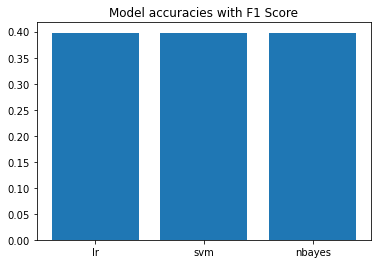

In [65]:
import matplotlib.pyplot as plt
plt.title("Model accuracies with F1 Score")
plt.bar(range(len(f1_scores_dictionary)), list(f1_scores_dictionary.values()), align='center')
plt.xticks(range(len(f1_scores_dictionary)), list(f1_scores_dictionary.keys()))

plt.show()

Conclusion : We can see SVM has a better f1 loss. 

# <b>Hamming Score </b>

The normal accuracy like F1 score, Recall does not work appropriatley because Recall, F1-Measure are designed for the binary class, 


<b>hamming Loss :<br></b>
Instead of Counting number of correctly classified data instance, Hamming Loss calculates loss generated in the bit string of class labels during prediction.
It <b>does XOR between general binary strings of class labels and predicted labels</b> for data instance and calculates avergae across the dataset

In [67]:
import numpy as np


def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)


In [68]:
hamming_scores= []
lr_hamming_score = hamming_score(y_val, y_pred_lr)
hamming_scores.append(lr_hamming_score)

nb_hamming_score = hamming_score(y_val, y_pred_nb)
hamming_scores.append(nb_hamming_score)

svm_hamming_score = hamming_score(y_val, y_pred_svm)
hamming_scores.append(svm_hamming_score)


In [69]:
# Dictionary is made to plot the graph
hamming_scores_dictionary = dict(zip(models, hamming_scores))

print(hamming_scores_dictionary)

{'lr': 0.23954111056187183, 'svm': 0.1761410446531554, 'nbayes': 0.32800811501071014}


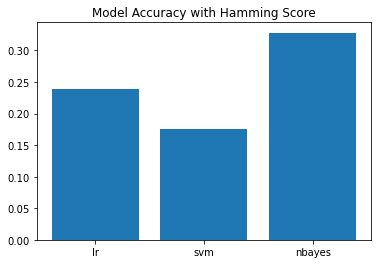

In [70]:
import matplotlib.pyplot as plt
plt.title("Model Accuracy with Hamming Score")
plt.bar(range(len(hamming_scores_dictionary)), list(hamming_scores_dictionary.values()), align='center')
plt.xticks(range(len(hamming_scores_dictionary)), list(hamming_scores_dictionary.keys()))

plt.show()

# Hyper Parameter tuning

Now, we will experiment a bit with training our classifiers by using weighted F1-score  as an evaluation metric. Moreover, we select to use the TF-IDF approach and try L1 and L2-regularization techniques in Logistic Regression with different coefficients (e.g. C equal to 0.1, 1, 10, 100).


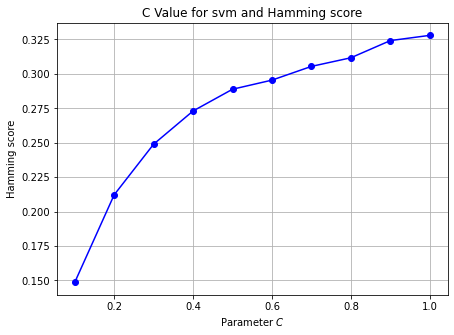

In [71]:
# for SVM
import matplotlib.pyplot as plt

hypers = np.arange(0.1, 1.1, 0.1)
res = []

for h in hypers:
    temp_model = train_classifier(xtrain_tfidf, y_train, C=h, model='svm')
    #temp_pred = f1_score(y_test, temp_model.predict(xtest_tfidf), average='weighted')
    temp_pred = hamming_score(y_val, temp_model.predict(xval_tfidf))
    res.append(temp_pred)

plt.figure(figsize=(7,5))
plt.plot(hypers, res, color='blue', marker='o')
plt.grid(True)
plt.title("C Value for svm and Hamming score")
plt.xlabel('Parameter $C$')
plt.ylabel('Hamming score')
plt.show()

SVM and LR can have different co-efficient values.  <br>
The graph shows that the <b>best co-efficient value</b> for svm is :<b> 1 </b>

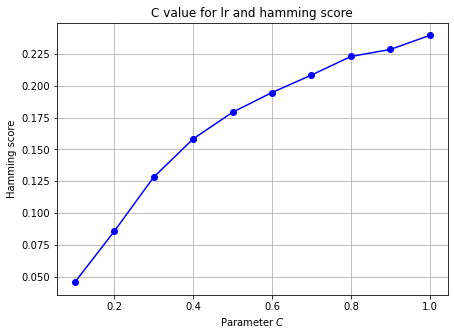

In [72]:
# for lr
import matplotlib.pyplot as plt

hypers = np.arange(0.1, 1.1, 0.1)
res = []

for h in hypers:
    temp_model = train_classifier(xtrain_tfidf, y_train, C=h, model='lr')
    #temp_pred = f1_score(y_test, temp_model.predict(xtest_tfidf), average='weighted')
    temp_pred = hamming_score(y_val, temp_model.predict(xval_tfidf))
    res.append(temp_pred)

plt.figure(figsize=(7,5))
plt.plot(hypers, res, color='blue', marker='o')
plt.grid(True)
plt.title("C value for lr and hamming score")
plt.xlabel('Parameter $C$')
plt.ylabel('Hamming score')
plt.show()

## Fit the "best" model and create predictions for test set



In [73]:
# Final model
C = 1.0
classifier = train_classifier(xtrain_tfidf, y_train, C=C, model='nbayes')

# Results
test_predictions =  classifier.predict(xtest_tfidf)
test_pred_inversed = mlb.inverse_transform(test_predictions)

test_pred_inversed

[('Mystery',),
 (),
 (),
 (),
 ('Fiction',),
 (),
 (),
 ('Science Fiction', 'Speculative fiction'),
 ('Fantasy', 'Speculative fiction'),
 ('Science Fiction', 'Speculative fiction'),
 (),
 ('Fiction',),
 ('Science Fiction', 'Speculative fiction'),
 ("Children's literature", 'Fiction'),
 (),
 (),
 (),
 ('Fantasy', 'Speculative fiction'),
 (),
 ("Children's literature", 'Fantasy', 'Speculative fiction'),
 (),
 (),
 ('Fantasy',),
 ('Fantasy', 'Speculative fiction'),
 ('Fiction',),
 ('Fantasy', 'Speculative fiction'),
 (),
 (),
 ('Fiction',),
 ("Children's literature", 'Fantasy'),
 ('Science Fiction', 'Speculative fiction'),
 (),
 ('Fiction',),
 (),
 (),
 (),
 (),
 ('Speculative fiction',),
 (),
 ('Science Fiction', 'Speculative fiction'),
 ('Science Fiction', 'Speculative fiction'),
 ('Science Fiction', 'Speculative fiction'),
 (),
 (),
 ('Science Fiction', 'Speculative fiction'),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('Science Fiction',),
 (),
 (),
 (),
 (),
 (),
 (),
 ('Spec

# Conclusion

This brings us to the end of this article. 

We can conclude that for the provided dataset, <b> Nbayes gives the best results</b>. Also if we want to <b>use "lr" </b> instead of naive bayes then we can use the <b>Hyper Parameter = 1  </b>
<br>
We can also observe that most of the genre are not being predicted. We can <b>further use Word2Vec, Neural networks </b>to improve the accuracy and predict the missed genres. 






Hope you got a basic understanding of how to solve a MultiLabel Classification Problem using Linear Models by following this post. 


# Further Research LDA

In [ ]:
!python -m spacy download en # one time run

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output




In [ ]:
tokenized_summary = pd.Series(summary).apply(lambda x: x.split())
#print(tokenized_summary[1])

summary_2 = lemmatization(tokenized_summary)



In [ ]:
from gensim import corpora
#create Dictionary
dictionary = corpora.Dictionary(summary_2)

In [ ]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in summary_2]

In [ ]:
import gensim
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

In [ ]:
lda_model.print_topics()

In [ ]:
train_vecs = []
for i in range(len(X_train)):
    top_topics = lda_model.get_document_topics(doc_term_matrix[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(7)]
     
    
    #topic_vec.extend([books.iloc[i].real_counts]) # counts of geners for summary
    topic_vec.extend([len(X_train[i])]) # length summary
    train_vecs.append(topic_vec)
    


In [ ]:
val_vecs = []
for i in range(len(X_val)):
    top_topics = lda_model.get_document_topics(doc_term_matrix[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(7)]
     
    
    #topic_vec.extend([books.iloc[i].real_counts]) # counts of geners for summary
    topic_vec.extend([len(X_train[i])]) # length summary
    val_vecs.append(topic_vec)
    

In [ ]:
len(train_vecs)

In [ ]:
len(val_vecs)

In [ ]:
x_train_lda = np.array(train_vecs)
y_train_lda = np.array(y_train)



In [ ]:
x_val_lda = np.array(val_vecs)



#####  You can use these X_val and x_train values instead of the above ones to find the loss and get a better model.



In [ ]:
#LDA
classifier_LDA = train_classifier(x_val_lda, y_train_lda, C=1.0, model='lr')

In [ ]:
# for LDA
y_pred_LDA = classifier_LDA.predict(X_val)
f1_score(y_val, y_pred_LDA, average="micro")

# can also try hamming score

## After Trying LDA, One can also try using Word2Vec